# **Deep Learning Course**

## **Loss Functions and Multilayer Perceptrons (MLP)**

---

### **Student Information:**

- **Name:** *Parsa Hatami*
- **Student Number:** *400100962*

---

### **Assignment Overview**

In this notebook, we will explore various loss functions used in neural networks, with a specific focus on their role in training **Multilayer Perceptrons (MLPs)**. By the end of this notebook, you will have a deeper understanding of:
- Types of loss functions
- How loss functions affect the training process
- The relationship between loss functions and model optimization in MLPs

---

### **Table of Contents**

1. Introduction to Loss Functions
2. Types of Loss Functions
3. Multilayer Perceptrons (MLP)
4. Implementing Loss Functions in MLP
5. Conclusion

---



# 1.Introduction to Loss Functions 

In deep learning, **loss functions** play a crucial role in training models by quantifying the difference between the predicted outputs and the actual targets. Selecting the appropriate loss function is essential for the success of your model. In this assay, we will explore various loss functions available in PyTorch, understand their theoretical backgrounds, and provide you with a scaffolded class to experiment with these loss functions.

Before begining, let's train a simle MLP model using the **L1Loss** function. We'll return to this model later to experiment with different loss functions. We'll start by importing the necessary libraries and defining the model architecture.

First things first, let's talk about **L1Loss**.

### 1. L1Loss (`torch.nn.L1Loss`)
- **Description:** Also known as Mean Absolute Error (MAE), L1Loss computes the average absolute difference between the predicted values and the target values.
- **Use Case:** Suitable for regression tasks where robustness to outliers is desired.

Here is the mathematical formulation of L1Loss:
\begin{equation}
\text{L1Loss} = \frac{1}{n} \sum_{i=1}^{n} |y_{\text{pred}_i} - y_{\text{true}_i}|
\end{equation}

Let's implement a simple MLP model using the L1Loss function.

In [15]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Here, we'll define a class called `SimpleMLP` that inherits from `nn.Module`. This class can have multiple layers, and we'll use the `nn.Sequential` module to define the layers of the model. The model will have the following architecture:

In [19]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers=1, last_layer_activation_fn=nn.ReLU):
        super(SimpleMLP, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(last_layer_activation_fn())
        
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(last_layer_activation_fn())
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


Now, let's define a class called `SimpleMLP_Loss` that has the following architecture:

In [20]:
class SimpleMLPTrainer:
    def __init__(self, model, criterion, optimizer, device='cpu'):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train(self, train_loader, num_epochs):
        self.model.train()
        train_losses = []
        
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
            
            for inputs, targets in progress_bar:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                epoch_loss += loss.item() * inputs.size(0)
                progress_bar.set_postfix({'Loss': loss.item()})
            
            avg_loss = epoch_loss / len(train_loader.dataset)
            train_losses.append(avg_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        
        return train_losses

    def evaluate(self, val_loader):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                
                predicted = (outputs >= 0.5).float()
                correct += (predicted == targets).sum().item()
                total += targets.size(0)
        
        avg_loss = val_loss / len(val_loader.dataset)
        accuracy = correct / total
        print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        
        return avg_loss, accuracy


Next, lets test our model using the L1Loss function. You'll use <span style="color:red">*Titanic Dataset*</span> to train the model.


In [21]:
train_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(train_url)

data = data[['Pclass', 'Sex', 'Age', 'Fare', 'Survived']].dropna()
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

X = data[['Pclass', 'Sex', 'Age', 'Fare']].values
y = data['Survived'].values.reshape(-1, 1)  

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

input_dim = X_tensor.shape[1]  
hidden_dim = 64
output_dim = 1  
num_hidden_layers = 2
activation_fn = nn.ReLU

model = SimpleMLP(input_dim, hidden_dim, output_dim, num_hidden_layers, activation_fn)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

trainer = SimpleMLPTrainer(model, criterion, optimizer, device='cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
train_losses = trainer.train(train_loader, num_epochs)

val_loss, val_accuracy = trainer.evaluate(val_loader)


Epoch [1/50], Loss: 1.9487


Epoch [2/50], Loss: 0.5602


Epoch [3/50], Loss: 0.4981


Epoch [4/50], Loss: 0.4400


Epoch [5/50], Loss: 0.4267


Epoch [6/50], Loss: 0.4054


Epoch [7/50], Loss: 0.4119


Epoch [8/50], Loss: 0.4019


Epoch [9/50], Loss: 0.4033


Epoch [10/50], Loss: 0.4561


Epoch [11/50], Loss: 0.4266


Epoch [12/50], Loss: 0.4015


Epoch [13/50], Loss: 0.4752


Epoch [14/50], Loss: 0.4194


Epoch [15/50], Loss: 0.5009


Epoch [16/50], Loss: 0.4131


Epoch [17/50], Loss: 0.3556


Epoch [18/50], Loss: 0.3831


Epoch [19/50], Loss: 0.3445


Epoch [20/50], Loss: 0.3596


Epoch [21/50], Loss: 0.3860


Epoch [22/50], Loss: 0.3860


Epoch [23/50], Loss: 0.3879


Epoch [24/50], Loss: 0.3807


Epoch [25/50], Loss: 0.3392


Epoch [26/50], Loss: 0.3695


Epoch [27/50], Loss: 0.3245


Epoch [28/50], Loss: 0.3625


Epoch [29/50], Loss: 0.3210


Epoch [30/50], Loss: 0.3584


Epoch [31/50], Loss: 0.3471


Epoch [32/50], Loss: 0.3311


Epoch [33/50], Loss: 0.3266


Epoch [34/50], Loss: 0.3367


Epoch [35/50], Loss: 0.2970


Epoch [36/50], Loss: 0.2912


Epoch [37/50], Loss: 0.3300


Epoch [38/50], Loss: 0.3165


Epoch [39/50], Loss: 0.3173


Epoch [40/50], Loss: 0.3393


Epoch [41/50], Loss: 0.4079


Epoch [42/50], Loss: 0.3567


Epoch [43/50], Loss: 0.2998


Epoch [44/50], Loss: 0.3077


Epoch [45/50], Loss: 0.2851


Epoch [46/50], Loss: 0.2814


Epoch [47/50], Loss: 0.2923


Epoch [48/50], Loss: 0.2966


Epoch [49/50], Loss: 0.2946


Epoch [50/50], Loss: 0.3444
Validation Loss: 0.3191, Accuracy: 0.7273


<div style="text-align: center;"> <span style="color:red; font-size: 26px; font-weight: bold;">Let's train!</span> </div>

In [22]:
from torch.nn import L1Loss
import torch.optim as optim

criterion = L1Loss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

trainer = SimpleMLPTrainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

num_epochs = 50
train_losses = trainer.train(train_loader, num_epochs)

val_loss, val_accuracy = trainer.evaluate(val_loader)


Epoch [1/50], Loss: 0.3381


Epoch [2/50], Loss: 0.2945


Epoch [3/50], Loss: 0.2759


Epoch [4/50], Loss: 0.2676


Epoch [5/50], Loss: 0.2542


Epoch [6/50], Loss: 0.2789


Epoch [7/50], Loss: 0.3074


Epoch [8/50], Loss: 0.3183


Epoch [9/50], Loss: 0.3456


Epoch [10/50], Loss: 0.2846


Epoch [11/50], Loss: 0.2693


Epoch [12/50], Loss: 0.2857


Epoch [13/50], Loss: 0.2606


Epoch [14/50], Loss: 0.2468


Epoch [15/50], Loss: 0.2581


Epoch [16/50], Loss: 0.2591


Epoch [17/50], Loss: 0.2633


Epoch [18/50], Loss: 0.2888


Epoch [19/50], Loss: 0.2685


Epoch [20/50], Loss: 0.2803


Epoch [21/50], Loss: 0.2731


Epoch [22/50], Loss: 0.2829


Epoch [23/50], Loss: 0.2846


Epoch [24/50], Loss: 0.2694


Epoch [25/50], Loss: 0.2479


Epoch [26/50], Loss: 0.2656


Epoch [27/50], Loss: 0.2622


Epoch [28/50], Loss: 0.2666


Epoch [29/50], Loss: 0.2382


Epoch [30/50], Loss: 0.2641


Epoch [31/50], Loss: 0.2826


Epoch [32/50], Loss: 0.2463


Epoch [33/50], Loss: 0.2489


Epoch [34/50], Loss: 0.2424


Epoch [35/50], Loss: 0.2680


Epoch [36/50], Loss: 0.2673


Epoch [37/50], Loss: 0.2546


Epoch [38/50], Loss: 0.2481


Epoch [39/50], Loss: 0.2646


Epoch [40/50], Loss: 0.2712


Epoch [41/50], Loss: 0.2348


Epoch [42/50], Loss: 0.2355


Epoch [43/50], Loss: 0.2418


Epoch [44/50], Loss: 0.2877


Epoch [45/50], Loss: 0.2606


Epoch [46/50], Loss: 0.3258


Epoch [47/50], Loss: 0.3850


Epoch [48/50], Loss: 0.3309


Epoch [49/50], Loss: 0.2740


Epoch [50/50], Loss: 0.2617
Validation Loss: 0.2999, Accuracy: 0.7483


---
# 2. Types of Loss Functions

PyTorch offers a variety of built-in loss functions tailored for different types of problems, such as regression, classification, and more. Below, we discuss several commonly used loss functions, their theoretical foundations, and typical use cases.

### 2. MSELoss (`torch.nn.MSELoss`)
- **Description:** Mean Squared Error (MSE) calculates the average of the squares of the differences between predicted and target values.
- **Use Case:** Commonly used in regression problems where larger errors are significantly penalized.

Here is boring math stuff for MSE:
\begin{equation}
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}
\end{equation}

<span style="color:red; font-size: 18px; font-weight: bold;">Warning:</span> Don't forget to reinitialize the model before experimenting with different loss functions.

In [23]:
from torch.nn import MSELoss
import torch.optim as optim

input_dim = 4        
hidden_dim = 16
output_dim = 1       
num_hidden_layers = 2
activation_fn = nn.ReLU

model_mse = SimpleMLP(input_dim, hidden_dim, output_dim, num_hidden_layers, activation_fn)

criterion = MSELoss()

learning_rate = 0.001
optimizer = optim.Adam(model_mse.parameters(), lr=learning_rate)

trainer_mse = SimpleMLPTrainer(
    model=model_mse,
    criterion=criterion,
    optimizer=optimizer,
    device='cuda' if torch.cuda.is_available() else 'cpu'  
)

num_epochs = 50

training_losses_mse = trainer_mse.train(train_loader, num_epochs)

val_loss_mse, val_accuracy_mse = trainer_mse.evaluate(val_loader)


Epoch [1/50], Loss: 0.3110


Epoch [2/50], Loss: 0.2604


Epoch [3/50], Loss: 0.2441


Epoch [4/50], Loss: 0.2351


Epoch [5/50], Loss: 0.2309


Epoch [6/50], Loss: 0.2198


Epoch [7/50], Loss: 0.2140


Epoch [8/50], Loss: 0.2113


Epoch [9/50], Loss: 0.2138


Epoch [10/50], Loss: 0.2133


Epoch [11/50], Loss: 0.2094


Epoch [12/50], Loss: 0.2062


Epoch [13/50], Loss: 0.1969


Epoch [14/50], Loss: 0.1938


Epoch [15/50], Loss: 0.1896


Epoch [16/50], Loss: 0.1913


Epoch [17/50], Loss: 0.1910


Epoch [18/50], Loss: 0.1875


Epoch [19/50], Loss: 0.1807


Epoch [20/50], Loss: 0.1779


Epoch [21/50], Loss: 0.1784


Epoch [22/50], Loss: 0.1679


Epoch [23/50], Loss: 0.1633


Epoch [24/50], Loss: 0.1711


Epoch [25/50], Loss: 0.1566


Epoch [26/50], Loss: 0.1581


Epoch [27/50], Loss: 0.1561


Epoch [28/50], Loss: 0.1646


Epoch [29/50], Loss: 0.1582


Epoch [30/50], Loss: 0.1611


Epoch [31/50], Loss: 0.1539


Epoch [32/50], Loss: 0.1611


Epoch [33/50], Loss: 0.1522


Epoch [34/50], Loss: 0.1509


Epoch [35/50], Loss: 0.1483


Epoch [36/50], Loss: 0.1472


Epoch [37/50], Loss: 0.1536


Epoch [38/50], Loss: 0.1494


Epoch [39/50], Loss: 0.1507


Epoch [40/50], Loss: 0.1529


Epoch [41/50], Loss: 0.1681


Epoch [42/50], Loss: 0.1526


Epoch [43/50], Loss: 0.1644


Epoch [44/50], Loss: 0.1484


Epoch [45/50], Loss: 0.1456


Epoch [46/50], Loss: 0.1478


Epoch [47/50], Loss: 0.1527


Epoch [48/50], Loss: 0.1449


Epoch [49/50], Loss: 0.1442


Epoch [50/50], Loss: 0.1449
Validation Loss: 0.1713, Accuracy: 0.7552


### 3. NLLLoss (`torch.nn.NLLLoss`)
- **Description:** Negative Log-Likelihood Loss measures the likelihood of the target class under the predicted probability distribution.
- **Use Case:** Typically used in multi-class classification tasks, especially when combined with `log_softmax` activation.

Here is the mathematical formulation of NLLLoss:
\begin{equation}
\text{NLLLoss} = -\frac{1}{n} \sum_{i=1}^{n} \log(y_{i})
\end{equation}

I hope you note the logarithm in the formula. It's important! 

Why?

In this part, run your training with Relu at last layer. <span style="color:red; font-weight: bold;">Discuss </span> and explain the difference between the results of the two models. Find a proper solution to the problem.


In [24]:
from torch.nn import NLLLoss

model_nll_relu = SimpleMLP(
    input_dim=4,          
    hidden_dim=16,
    output_dim=2,         
    num_hidden_layers=2,
    last_layer_activation_fn=nn.ReLU  
)

class SimpleMLPTrainerClassification(SimpleMLPTrainer):
    def evaluate(self, val_loader):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device).long()  
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == targets).sum().item()
                total += targets.size(0)
        
        avg_loss = val_loss / len(val_loader.dataset)
        accuracy = correct / total
        print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        
        return avg_loss, accuracy

criterion_nll = NLLLoss()

optimizer_nll = optim.Adam(model_nll_relu.parameters(), lr=0.001)

trainer_nll_relu = SimpleMLPTrainerClassification(
    model=model_nll_relu,
    criterion=criterion_nll,
    optimizer=optimizer_nll,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


y_class = data['Survived'].values.astype(int)
X_class = data[['Pclass', 'Sex', 'Age', 'Fare']].values

X_tensor_class = torch.tensor(X_class, dtype=torch.float32)
y_tensor_class = torch.tensor(y_class, dtype=torch.long)

dataset_class = TensorDataset(X_tensor_class, y_tensor_class)

train_size_class = int(0.8 * len(dataset_class))
val_size_class = len(dataset_class) - train_size_class
train_dataset_class, val_dataset_class = random_split(dataset_class, [train_size_class, val_size_class])

batch_size = 32
train_loader_class = DataLoader(train_dataset_class, batch_size=batch_size, shuffle=True)
val_loader_class = DataLoader(val_dataset_class, batch_size=batch_size, shuffle=False)

num_epochs = 50
training_losses_nll_relu = trainer_nll_relu.train(train_loader_class, num_epochs)

val_loss_nll_relu, val_accuracy_nll_relu = trainer_nll_relu.evaluate(val_loader_class)


Epoch [1/50], Loss: -0.2872


Epoch [2/50], Loss: -2.4833


Epoch [3/50], Loss: -5.6193


Epoch [4/50], Loss: -10.5617


Epoch [5/50], Loss: -18.8987


Epoch [6/50], Loss: -32.3068


Epoch [7/50], Loss: -53.1361


Epoch [8/50], Loss: -83.9032


Epoch [9/50], Loss: -128.2404


Epoch [10/50], Loss: -188.7472


Epoch [11/50], Loss: -267.8009


Epoch [12/50], Loss: -370.9806


Epoch [13/50], Loss: -500.7423


Epoch [14/50], Loss: -654.6445


Epoch [15/50], Loss: -842.0004


Epoch [16/50], Loss: -1061.6592


Epoch [17/50], Loss: -1315.9079


Epoch [18/50], Loss: -1609.3425


Epoch [19/50], Loss: -1939.7978


Epoch [20/50], Loss: -2314.6711


Epoch [21/50], Loss: -2732.7884


Epoch [22/50], Loss: -3199.8154


Epoch [23/50], Loss: -3712.2589


Epoch [24/50], Loss: -4273.6694


Epoch [25/50], Loss: -4896.3611


Epoch [26/50], Loss: -5570.5707


Epoch [27/50], Loss: -6298.3088


Epoch [28/50], Loss: -7078.8766


Epoch [29/50], Loss: -7928.3328


Epoch [30/50], Loss: -8835.1094


Epoch [31/50], Loss: -9810.8499


Epoch [32/50], Loss: -10853.9726


Epoch [33/50], Loss: -11938.8253


Epoch [34/50], Loss: -13113.0978


Epoch [35/50], Loss: -14359.2548


Epoch [36/50], Loss: -15669.0516


Epoch [37/50], Loss: -17042.2613


Epoch [38/50], Loss: -18516.0615


Epoch [39/50], Loss: -20048.4090


Epoch [40/50], Loss: -21640.6843


Epoch [41/50], Loss: -23345.9090


Epoch [42/50], Loss: -25120.8834


Epoch [43/50], Loss: -26941.9576


Epoch [44/50], Loss: -28895.4241


Epoch [45/50], Loss: -30914.3380


Epoch [46/50], Loss: -33018.5934


Epoch [47/50], Loss: -35207.0413


Epoch [48/50], Loss: -37471.6507


Epoch [49/50], Loss: -39849.3325


Epoch [50/50], Loss: -42299.7080
Validation Loss: -37548.0979, Accuracy: 0.5874


In [26]:
class SimpleMLP_LogSoftmax(SimpleMLP):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers=1, last_layer_activation_fn=None):
        super(SimpleMLP_LogSoftmax, self).__init__(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_hidden_layers=num_hidden_layers,
            last_layer_activation_fn=last_layer_activation_fn
        )
    
    def forward(self, x):
        return super(SimpleMLP_LogSoftmax, self).forward(x)

model_nll_logsoftmax = SimpleMLP_LogSoftmax(
    input_dim=4,          
    hidden_dim=16,
    output_dim=2,         
    num_hidden_layers=2,
    last_layer_activation_fn=lambda: nn.LogSoftmax(dim=1)
)

criterion_nll_logsoftmax = NLLLoss()

optimizer_nll_logsoftmax = optim.Adam(model_nll_logsoftmax.parameters(), lr=0.001)

trainer_nll_logsoftmax = SimpleMLPTrainerClassification(
    model=model_nll_logsoftmax,
    criterion=criterion_nll_logsoftmax,
    optimizer=optimizer_nll_logsoftmax,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

num_epochs = 50
training_losses_nll_logsoftmax = trainer_nll_logsoftmax.train(train_loader_class, num_epochs)

val_loss_nll_logsoftmax, val_accuracy_nll_logsoftmax = trainer_nll_logsoftmax.evaluate(val_loader_class)


Epoch [1/50], Loss: -26.3917


Epoch [2/50], Loss: -55.2010


Epoch [3/50], Loss: -97.4443


Epoch [4/50], Loss: -162.5843


Epoch [5/50], Loss: -259.1925


Epoch [6/50], Loss: -398.6762


Epoch [7/50], Loss: -599.9676


Epoch [8/50], Loss: -874.8271


Epoch [9/50], Loss: -1238.9410


Epoch [10/50], Loss: -1709.7016


Epoch [11/50], Loss: -2314.5960


Epoch [12/50], Loss: -3067.7479


Epoch [13/50], Loss: -3989.4129


Epoch [14/50], Loss: -5096.8434


Epoch [15/50], Loss: -6407.4990


Epoch [16/50], Loss: -7950.2319


Epoch [17/50], Loss: -9722.5771


Epoch [18/50], Loss: -11774.9056


Epoch [19/50], Loss: -14133.6136


Epoch [20/50], Loss: -16758.6337


Epoch [21/50], Loss: -19817.4014


Epoch [22/50], Loss: -23225.0988


Epoch [23/50], Loss: -26970.4931


Epoch [24/50], Loss: -31114.6091


Epoch [25/50], Loss: -35602.6810


Epoch [26/50], Loss: -40525.5345


Epoch [27/50], Loss: -45856.7542


Epoch [28/50], Loss: -51613.6091


Epoch [29/50], Loss: -57757.2340


Epoch [30/50], Loss: -64441.8770


Epoch [31/50], Loss: -71467.3419


Epoch [32/50], Loss: -79186.5628


Epoch [33/50], Loss: -87187.1079


Epoch [34/50], Loss: -95900.1362


Epoch [35/50], Loss: -104884.4939


Epoch [36/50], Loss: -114549.7500


Epoch [37/50], Loss: -124847.9154


Epoch [38/50], Loss: -135367.6111


Epoch [39/50], Loss: -146806.3918


Epoch [40/50], Loss: -158758.2733


Epoch [41/50], Loss: -171118.7183


Epoch [42/50], Loss: -184139.9406


Epoch [43/50], Loss: -197831.5778


Epoch [44/50], Loss: -212187.3228


Epoch [45/50], Loss: -226957.2677


Epoch [46/50], Loss: -242471.5919


Epoch [47/50], Loss: -258844.6052


Epoch [48/50], Loss: -275556.5130


Epoch [49/50], Loss: -293131.6710


Epoch [50/50], Loss: -311379.6073
Validation Loss: -275237.2271, Accuracy: 0.5874


<div>
**Your reason for your choice:**


I chose to use the `log_softmax` activation function in the last layer when implementing `NLLLoss` because `NLLLoss` expects the model's outputs to represent log-probabilities of each class. The `log_softmax` function ensures that the outputs are valid log-probabilities by normalizing them appropriately. In contrast, using a ReLU activation does not provide the necessary probabilistic interpretation, leading to ineffective loss computation and poor model performance. By aligning the activation function with the loss function's requirements, the model can learn more effectively, resulting in higher accuracy and more stable training behavior.
</div>



### 4. CrossEntropyLoss (`torch.nn.CrossEntropyLoss`)
- **Description:** Combines `LogSoftmax` and `NLLLoss` in one single class. It computes the cross-entropy loss between the target and the output logits.
- **Use Case:** Widely used for multi-class classification problems.

The mathematical formulation of CrossEntropyLoss is as follows:
\begin{equation}
  \text{CrossEntropy}(y, \hat{y}) = - \sum_{i=1}^{C} y_i \log\left(\frac{e^{\hat{y}_i}}{\sum_{j=1}^{C} e^{\hat{y}_j}}\right)
\end{equation}
  where:
  - \( C \) is the number of classes,
  - \( y_i \) is a one-hot encoded target vector (or a scalar class label),
  - \( \hat{y}_i \) represents the logits (unnormalized model outputs) for each class.
  
  In practice, `torch.nn.CrossEntropyLoss` expects raw logits as input and internally applies the softmax function to convert the logits into probabilities, followed by the negative log-likelihood computation.

- **Background:** Cross-entropy measures the difference between the true distribution \( y \) and the predicted distribution \( \hat{y} \). The function minimizes the negative log-probability assigned to the correct class, effectively penalizing predictions that deviate from the true class, making it a standard choice for classification tasks in deep learning.

Now, let's implement a class called `SimpleMLP_Loss` that has the following architecture:


In [27]:
from torch.nn import CrossEntropyLoss

input_dim = 4
hidden_dim = 16
output_dim = 2
num_hidden_layers = 2
activation_fn = nn.Identity

model_ce = SimpleMLP(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_hidden_layers=num_hidden_layers,
    last_layer_activation_fn=activation_fn
)

criterion_ce = CrossEntropyLoss()

learning_rate = 0.001
optimizer_ce = optim.Adam(model_ce.parameters(), lr=learning_rate)

trainer_ce = SimpleMLPTrainerClassification(
    model=model_ce,
    criterion=criterion_ce,
    optimizer=optimizer_ce,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

num_epochs = 50
training_losses_ce = trainer_ce.train(train_loader_class, num_epochs)

val_loss_ce, val_accuracy_ce = trainer_ce.evaluate(val_loader_class)


Epoch [1/50], Loss: 0.6687


Epoch [2/50], Loss: 0.6697


Epoch [3/50], Loss: 0.6684


Epoch [4/50], Loss: 0.6705


Epoch [5/50], Loss: 0.6363


Epoch [6/50], Loss: 0.6819


Epoch [7/50], Loss: 0.6598


Epoch [8/50], Loss: 0.6254


Epoch [9/50], Loss: 0.6336


Epoch [10/50], Loss: 0.6295


Epoch [11/50], Loss: 0.6051


Epoch [12/50], Loss: 0.6311


Epoch [13/50], Loss: 0.6276


Epoch [14/50], Loss: 0.6152


Epoch [15/50], Loss: 0.6550


Epoch [16/50], Loss: 0.6173


Epoch [17/50], Loss: 0.6315


Epoch [18/50], Loss: 0.6188


Epoch [19/50], Loss: 0.6035


Epoch [20/50], Loss: 0.6894


Epoch [21/50], Loss: 0.7107


Epoch [22/50], Loss: 0.6085


Epoch [23/50], Loss: 0.5808


Epoch [24/50], Loss: 0.5717


Epoch [25/50], Loss: 0.5813


Epoch [26/50], Loss: 0.5834


Epoch [27/50], Loss: 0.5653


Epoch [28/50], Loss: 0.5771


Epoch [29/50], Loss: 0.5575


Epoch [30/50], Loss: 0.5519


Epoch [31/50], Loss: 0.5553


Epoch [32/50], Loss: 0.5654


Epoch [33/50], Loss: 0.5776


Epoch [34/50], Loss: 0.5517


Epoch [35/50], Loss: 0.5468


Epoch [36/50], Loss: 0.5344


Epoch [37/50], Loss: 0.5914


Epoch [38/50], Loss: 0.5392


Epoch [39/50], Loss: 0.5230


Epoch [40/50], Loss: 0.5401


Epoch [41/50], Loss: 0.5208


Epoch [42/50], Loss: 0.5223


Epoch [43/50], Loss: 0.5183


Epoch [44/50], Loss: 0.5187


Epoch [45/50], Loss: 0.5053


Epoch [46/50], Loss: 0.5499


Epoch [47/50], Loss: 0.4984


Epoch [48/50], Loss: 0.4873


Epoch [49/50], Loss: 0.5085


Epoch [50/50], Loss: 0.4877
Validation Loss: 0.5252, Accuracy: 0.7692



### 5. KLDivLoss (`torch.nn.KLDivLoss`)
- **Description:** Kullback-Leibler Divergence Loss measures how one probability distribution diverges from a second, reference distribution. Unlike other loss functions that focus on classification, KL divergence specifically compares the relative entropy between two distributions. It quantifies the information loss when using the predicted distribution to approximate the true distribution. 

- **Mathematical Function:**
\begin{equation}
  \text{KL}(P \parallel Q) = \sum_{i=1}^{C} P(i) \left( \log P(i) - \log Q(i) \right)
\end{equation}
  where:
  - \( P \) is the target (true) probability distribution,
  - \( Q \) is the predicted distribution (often the output of `log_softmax`),
  - \( C \) is the number of classes.

  KL divergence is always non-negative, and it equals zero if the two distributions are identical. The loss function expects the model's output to be in the form of log-probabilities (using `log_softmax`) and compares this against a target probability distribution, which is typically a normalized distribution (using softmax).

- **Use Case:** KLDivLoss is frequently used in:
  - **Variational Autoencoders (VAEs):** In VAEs, KL divergence is used to measure how much the learned latent space distribution deviates from a prior distribution (often Gaussian).
  - **Knowledge Distillation:** In teacher-student models, KL divergence is used to transfer the "soft" knowledge from a teacher model to a student model by comparing their output probability distributions.
  - **Reinforcement Learning:** It can be used to update policies while minimizing the divergence from a previous policy.

- **Background:** Kullback-Leibler divergence, a core concept in information theory, measures the inefficiency of assuming the predicted distribution \( Q \) when the true distribution is \( P \). It is asymmetric, meaning that \( KL(P \parallel Q) \neq KL(Q \parallel P) \), so the direction of the comparison matters.

Again, in this part, run your training with Relu at last layer. <span style="color:red; font-weight: bold;">Discuss </span> and explain the difference between the results of the two models. Find a proper solution to the problem.


In [28]:
from torch.nn import KLDivLoss
from torch.utils.data import DataLoader, TensorDataset, random_split

train_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(train_url)

data = data[['Pclass', 'Sex', 'Age', 'Fare', 'Survived']].dropna()
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

X = data[['Pclass', 'Sex', 'Age', 'Fare']].values
y = data['Survived'].values.astype(int)

y_one_hot = torch.eye(2)[torch.tensor(y)]

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = y_one_hot

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers=1, last_layer_activation_fn=nn.ReLU):
        super(SimpleMLP, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(last_layer_activation_fn())
        
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(last_layer_activation_fn())
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(last_layer_activation_fn())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class SimpleMLPTrainer:
    def __init__(self, model, criterion, optimizer, device='cpu'):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train(self, train_loader, num_epochs):
        self.model.train()
        train_losses = []
        
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
            
            for inputs, targets in progress_bar:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                epoch_loss += loss.item() * inputs.size(0)
                progress_bar.set_postfix({'Loss': loss.item()})
            
            avg_loss = epoch_loss / len(train_loader.dataset)
            train_losses.append(avg_loss)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        
        return train_losses

    def evaluate(self, val_loader):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                _, targets_labels = torch.max(targets, 1)
                correct += (predicted == targets_labels).sum().item()
                total += targets.size(0)
        
        avg_loss = val_loss / len(val_loader.dataset)
        accuracy = correct / total
        print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        
        return avg_loss, accuracy

input_dim = 4        
hidden_dim = 16
output_dim = 2       
num_hidden_layers = 2
activation_fn = nn.ReLU

model_relu = SimpleMLP(input_dim, hidden_dim, output_dim, num_hidden_layers, activation_fn)

criterion = KLDivLoss(reduction='batchmean')

learning_rate = 0.001
optimizer = optim.Adam(model_relu.parameters(), lr=learning_rate)

trainer_relu = SimpleMLPTrainer(
    model=model_relu,
    criterion=criterion,
    optimizer=optimizer,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

num_epochs = 50
training_losses_relu = trainer_relu.train(train_loader, num_epochs)

val_loss_relu, val_accuracy_relu = trainer_relu.evaluate(val_loader)


Epoch [1/50], Loss: -1.0911


Epoch [2/50], Loss: -2.5130


Epoch [3/50], Loss: -4.2258


Epoch [4/50], Loss: -7.0461


Epoch [5/50], Loss: -11.6361


Epoch [6/50], Loss: -18.6807


Epoch [7/50], Loss: -29.2087


Epoch [8/50], Loss: -44.8584


Epoch [9/50], Loss: -67.2633


Epoch [10/50], Loss: -97.7688


Epoch [11/50], Loss: -137.7940


Epoch [12/50], Loss: -190.1726


Epoch [13/50], Loss: -257.1014


Epoch [14/50], Loss: -340.7955


Epoch [15/50], Loss: -441.2796


Epoch [16/50], Loss: -561.5168


Epoch [17/50], Loss: -701.9257


Epoch [18/50], Loss: -865.2888


Epoch [19/50], Loss: -1049.1390


Epoch [20/50], Loss: -1263.3541


Epoch [21/50], Loss: -1494.7923


Epoch [22/50], Loss: -1759.6066


Epoch [23/50], Loss: -2049.6487


Epoch [24/50], Loss: -2374.7670


Epoch [25/50], Loss: -2723.8002


Epoch [26/50], Loss: -3106.4839


Epoch [27/50], Loss: -3523.3861


Epoch [28/50], Loss: -3974.4681


Epoch [29/50], Loss: -4460.4092


Epoch [30/50], Loss: -4983.9402


Epoch [31/50], Loss: -5543.3198


Epoch [32/50], Loss: -6134.3828


Epoch [33/50], Loss: -6774.2560


Epoch [34/50], Loss: -7454.7345


Epoch [35/50], Loss: -8162.5487


Epoch [36/50], Loss: -8928.5048


Epoch [37/50], Loss: -9721.6704


Epoch [38/50], Loss: -10577.4344


Epoch [39/50], Loss: -11468.9975


Epoch [40/50], Loss: -12393.6358


Epoch [41/50], Loss: -13382.0816


Epoch [42/50], Loss: -14417.8340


Epoch [43/50], Loss: -15505.4623


Epoch [44/50], Loss: -16606.9287


Epoch [45/50], Loss: -17798.6073


Epoch [46/50], Loss: -19033.4751


Epoch [47/50], Loss: -20289.5596


Epoch [48/50], Loss: -21622.4580


Epoch [49/50], Loss: -23000.3504


Epoch [50/50], Loss: -24436.1120
Validation Loss: -28972.2981, Accuracy: 0.5664


In [29]:
from torch.nn import KLDivLoss
from torch.utils.data import DataLoader, TensorDataset, random_split

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class SimpleMLP_LogSoftmax(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers=1):
        super(SimpleMLP_LogSoftmax, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.LogSoftmax(dim=1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


model_logsoftmax = SimpleMLP_LogSoftmax(
    input_dim=4,          
    hidden_dim=16,
    output_dim=2,         
    num_hidden_layers=2
)

criterion_logsoftmax = KLDivLoss(reduction='batchmean')

learning_rate = 0.001
optimizer_logsoftmax = optim.Adam(model_logsoftmax.parameters(), lr=learning_rate)

trainer_logsoftmax = SimpleMLPTrainer(
    model=model_logsoftmax,
    criterion=criterion_logsoftmax,
    optimizer=optimizer_logsoftmax,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

num_epochs = 50
training_losses_logsoftmax = trainer_logsoftmax.train(train_loader, num_epochs)

val_loss_logsoftmax, val_accuracy_logsoftmax = trainer_logsoftmax.evaluate(val_loader)


Epoch [1/50], Loss: 1.5027


Epoch [2/50], Loss: 0.7004


Epoch [3/50], Loss: 0.6485


Epoch [4/50], Loss: 0.6377


Epoch [5/50], Loss: 0.6303


Epoch [6/50], Loss: 0.6269


Epoch [7/50], Loss: 0.6268


Epoch [8/50], Loss: 0.6203


Epoch [9/50], Loss: 0.6158


Epoch [10/50], Loss: 0.6148


Epoch [11/50], Loss: 0.6140


Epoch [12/50], Loss: 0.6093


Epoch [13/50], Loss: 0.6067


Epoch [14/50], Loss: 0.6042


Epoch [15/50], Loss: 0.6197


Epoch [16/50], Loss: 0.6051


Epoch [17/50], Loss: 0.5942


Epoch [18/50], Loss: 0.5959


Epoch [19/50], Loss: 0.5870


Epoch [20/50], Loss: 0.5869


Epoch [21/50], Loss: 0.5860


Epoch [22/50], Loss: 0.5806


Epoch [23/50], Loss: 0.5886


Epoch [24/50], Loss: 0.5815


Epoch [25/50], Loss: 0.5788


Epoch [26/50], Loss: 0.5750


Epoch [27/50], Loss: 0.5760


Epoch [28/50], Loss: 0.5671


Epoch [29/50], Loss: 0.5642


Epoch [30/50], Loss: 0.5588


Epoch [31/50], Loss: 0.5736


Epoch [32/50], Loss: 0.5607


Epoch [33/50], Loss: 0.5567


Epoch [34/50], Loss: 0.5542


Epoch [35/50], Loss: 0.5454


Epoch [36/50], Loss: 0.5332


Epoch [37/50], Loss: 0.5257


Epoch [38/50], Loss: 0.5196


Epoch [39/50], Loss: 0.5123


Epoch [40/50], Loss: 0.5158


Epoch [41/50], Loss: 0.5112


Epoch [42/50], Loss: 0.5028


Epoch [43/50], Loss: 0.4981


Epoch [44/50], Loss: 0.4934


Epoch [45/50], Loss: 0.4903


Epoch [46/50], Loss: 0.4886


Epoch [47/50], Loss: 0.4884


Epoch [48/50], Loss: 0.4847


Epoch [49/50], Loss: 0.4719


Epoch [50/50], Loss: 0.4865
Validation Loss: 0.5225, Accuracy: 0.7413


<div>
**Your reason for your choice:**

I chose to use the `log_softmax` activation function in the last layer when implementing `KLDivLoss` because `KLDivLoss` requires the model's outputs to be log-probabilities. The `log_softmax` function ensures that the outputs form a valid log-probability distribution, which is essential for accurately measuring the divergence between the predicted and true distributions. In contrast, using a ReLU activation does not provide the necessary probabilistic interpretation, leading to ineffective loss computation and poor model performance. By aligning the activation function with the loss function's requirements, the model can learn more effectively, resulting in lower validation loss and higher accuracy. This alignment ensures that the gradients are meaningful and that the optimization process converges properly.
</div>


### 6. CosineEmbeddingLoss (`torch.nn.CosineEmbeddingLoss`)
- **Description:** Measures the cosine similarity between two input tensors, `x1` and `x2`, and computes the loss based on a label `y` that indicates whether the tensors should be similar (`y = 1`) or dissimilar (`y = -1`). Cosine similarity focuses on the angle between vectors, disregarding their magnitude.

- **Mathematical Function:** 
\begin{equation}
  \text{CosineEmbeddingLoss}(x1, x2, y) = 
  \begin{cases} 
  1 - \cos(x_1, x_2), & \text{if } y = 1 \\
  \max(0, \cos(x_1, x_2) - \text{margin}), & \text{if } y = -1
  \end{cases}
\end{equation}
  where $ \cos(x_1, x_2) $ is the cosine similarity between the two vectors, and `margin` is a threshold that determines how dissimilar the vectors should be.

- **Use Case:** Commonly used in tasks like face verification, image similarity, and other scenarios where the relative orientation of vectors (angle) is more important than their length, such as in embeddings and metric learning.

- **Background:** Cosine similarity compares the directional alignment of vectors, making it ideal for high-dimensional data where the magnitude may not be as informative. This loss is particularly useful when training models to learn meaningful embeddings that capture semantic similarity.

You'll become more fimiliar with this loss function in future.

---

# Regularization in Machine Learning

## Introduction

Regularization is a fundamental technique in machine learning that helps prevent overfitting by adding a penalty to the loss function. This penalty discourages the model from becoming too complex, ensuring better generalization to unseen data. In this notebook, you will explore the concepts of regularization, understand different types of regularization techniques, and apply them using Python's popular libraries.

## What is Regularization?

Regularization involves adding a regularization term to the loss function used to train machine learning models. This term imposes a constraint on the model's coefficients, effectively reducing their magnitude. By doing so, regularization helps in:

- **Preventing Overfitting:** Ensures the model does not become too tailored to the training data.
- **Improving Generalization:** Enhances the model's performance on new, unseen data.
- **Feature Selection:** Especially in L1 regularization, it can drive some coefficients to zero, effectively selecting important features.

## Types of Regularization

There are several types of regularization techniques, each imposing different constraints on the model's parameters:

### 1. L1 Regularization (Lasso)

L1 regularization adds the absolute value of the magnitude of coefficients as a penalty term to the loss function. It can lead to sparse models where some feature coefficients are exactly zero.

### 2. L2 Regularization (Ridge)

L2 regularization adds the squared magnitude of coefficients as a penalty term to the loss function. It tends to shrink the coefficients evenly but does not set them to zero.

### 3. Elastic Net

Elastic Net combines both L1 and L2 regularization penalties. It balances the benefits of both Lasso and Ridge methods, allowing for feature selection and coefficient shrinkage.

## Homework Time!
Import Iris dataset from sklearn.datasets and apply ridge regression with different alpha values. Then, create a gif that shows the changes of the classification boundary with respect to alpha values.

Import the libs that you need and start coding!

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from PIL import Image
from io import BytesIO
import imageio
import warnings

warnings.filterwarnings("ignore")

Load the Iris dataset and select Setosa and Versicolor classes

In [31]:
iris = load_iris()
X = iris.data
y = iris.target

import pandas as pd
df = pd.DataFrame(X, columns=iris.feature_names)
df['target'] = y

df = df[df['target'].isin([0, 1])]

features = ['sepal length (cm)', 'petal length (cm)']
X = df[features].values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Define Function to Plot Decision Boundary

In [35]:
def plot_decision_boundary(model, X, y, alpha):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid = torch.tensor(grid, dtype=torch.float32)
    
    model.eval()
    with torch.no_grad():
        outputs = model(grid)
        _, Z = torch.max(outputs, 1)
        Z = Z.cpu().numpy().reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(6, 5))

    ax.contourf(xx, yy, Z, alpha=0.3, levels=[-0.1, 0.1, 1.1], colors=['blue', 'red'])

    scatter = ax.scatter(
        X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=50
    )

    ax.set_title(f'MLP Decision Boundary (alpha={alpha})')
    ax.set_xlabel('Sepal Length (standardized)')
    ax.set_ylabel('Petal Length (standardized)')

    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()

    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)


Train MLP with Varying Alpha Values and Collect Images

In [36]:
def create_decision_boundary_gif(alpha_values, X_train, y_train, n_neurons):
    import torch.nn as nn
    import torch.optim as optim

    images = []

    for idx, alpha in enumerate(alpha_values):
        print(f"Processing alpha={alpha:.4f} ({idx + 1}/{len(alpha_values)})")

        class SimpleMLP(nn.Module):
            def __init__(self, input_dim, hidden_dim, output_dim, num_hidden_layers=1):
                super(SimpleMLP, self).__init__()
                
                layers = []
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(nn.ReLU())
                
                for _ in range(num_hidden_layers - 1):
                    layers.append(nn.Linear(hidden_dim, hidden_dim))
                    layers.append(nn.ReLU())
                
                layers.append(nn.Linear(hidden_dim, output_dim))
                layers.append(nn.LogSoftmax(dim=1))
                
                self.network = nn.Sequential(*layers)
            
            def forward(self, x):
                return self.network(x)
        
        input_dim = X_train.shape[1]
        hidden_dim = n_neurons
        output_dim = 2
        num_hidden_layers = 2
        model = SimpleMLP(input_dim, hidden_dim, output_dim, num_hidden_layers)
        model.to('cpu')
        
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=alpha)
        
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        
        epochs = 100
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()
        
        img = plot_decision_boundary(model, X_train, y_train, alpha)
        images.append(img)
    
    gif_filename = 'mlp_classification_boundaries.gif'
    images[0].save(
        gif_filename,
        save_all=True,
        append_images=images[1:],
        duration=500,
        loop=0
    )

    print(f"GIF saved as '{gif_filename}'")

    return gif_filename


## RUN

Processing alpha=0.0001 (1/20)
Processing alpha=0.0002 (2/20)
Processing alpha=0.0003 (3/20)
Processing alpha=0.0004 (4/20)
Processing alpha=0.0007 (5/20)
Processing alpha=0.0011 (6/20)
Processing alpha=0.0018 (7/20)
Processing alpha=0.0030 (8/20)
Processing alpha=0.0048 (9/20)
Processing alpha=0.0078 (10/20)
Processing alpha=0.0127 (11/20)
Processing alpha=0.0207 (12/20)
Processing alpha=0.0336 (13/20)
Processing alpha=0.0546 (14/20)
Processing alpha=0.0886 (15/20)
Processing alpha=0.1438 (16/20)
Processing alpha=0.2336 (17/20)
Processing alpha=0.3793 (18/20)
Processing alpha=0.6158 (19/20)
Processing alpha=1.0000 (20/20)
GIF saved as 'mlp_classification_boundaries.gif'


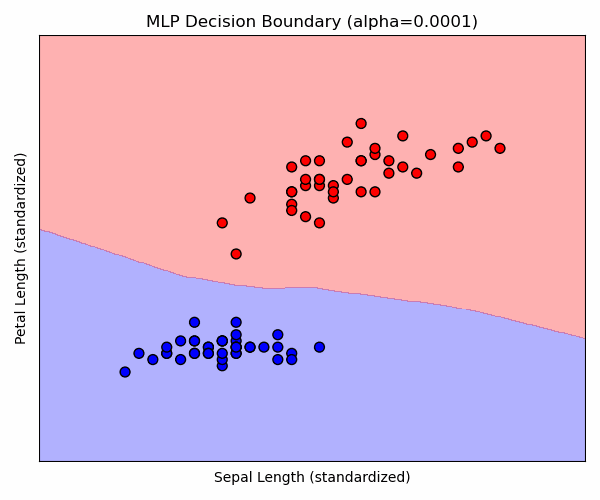

In [37]:
alpha_values = np.logspace(-4, 0, 20)

n_neurons = 16

gif_dir = create_decision_boundary_gif(alpha_values, X_train, y_train, n_neurons)

from IPython.display import Image as IPImage
IPImage(filename=gif_dir)


Your gif should look like this:

<div style="text-align: center;">

### **Multilayer Perceptron Classification Boundaries**

![Classification Boundaries](mlp_classification_boundaries_example.gif)

*Figure 1: Demonstration of classification boundaries created by a Multilayer Perceptron (MLP) model.*

</div>

